# Lab 4

## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

### Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


### Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

In [4]:
import cv2

def load_normalize_images(image_paths):
    images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        img = cv2.resize(img, (128, 128))  # resize
        img = img / 255.0  # normalize
        images.append(img)
    return np.array(images)

train_images=load_normalize_images(train_images_dir)
test_images=load_normalize_images(test_images_dir)



In [5]:
train_images[0].shape

(128, 128)

### Model Training

In [6]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [ ]:
from keras.optimizers import Adam 
EPOCHS = 6
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CATEGORIES = 2
TEST_SIZE = 0.2



model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),padding='same', activation="relu", input_shape=(128, 128,1)),
   # tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
    tf.keras.layers.Conv2D(16, (3, 3),padding='same', activation="relu"),
   # tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
    #tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
])

model.compile(optimizer = Adam(0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(np.asarray(train_images, dtype=np.float32), np.asarray(train_labels), batch_size=128, epochs=50, validation_split=0.2, shuffle=True)


### SGD Classifier 

In [7]:
train_images = train_images.reshape(train_images.shape[0], -1)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(train_images, train_labels)

SGDClassifier(random_state=42)

In [9]:
test_images = test_images.reshape(test_images.shape[0], -1)

In [10]:
sgd_clf.predict(test_images)

array([1, 1, 1, ..., 0, 0, 0])

### Model Evaluation - SGD Classifier

In [11]:
predictions = sgd_clf.predict(test_images)

#### Accuracy

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, predictions)
accuracy

0.9738333333333333

#### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(test_labels, predictions)
confusion_matrix

array([[2843,  157],
       [   0, 3000]], dtype=int64)

In [18]:
tp = confusion_matrix[0,0]
tn = confusion_matrix[1,1]
fp = confusion_matrix[1,0]
fn = confusion_matrix[0,1]

#### TP Rate = TP/ (TP+FN)

In [19]:
tp_rate = tp / (tp + fn)
tp_rate

0.9476666666666667

#### FP Rate = FP/(FP+TN)

In [21]:
fp_rate = fp / (fp + tn)
fp_rate

0.0

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

#### Precison

In [42]:
precision_2 = precision_score(test_labels, predictions)
precision_2

0.9502692429521697

#### Recall

In [43]:
recall_2 = recall_score(test_labels, predictions)
recall_2

1.0

#### F-measure

In [44]:
f1 = f1_score(test_labels, predictions)
f1

0.974500568458665

#### ROC Curve

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, sgd_clf.decision_function(test_images))

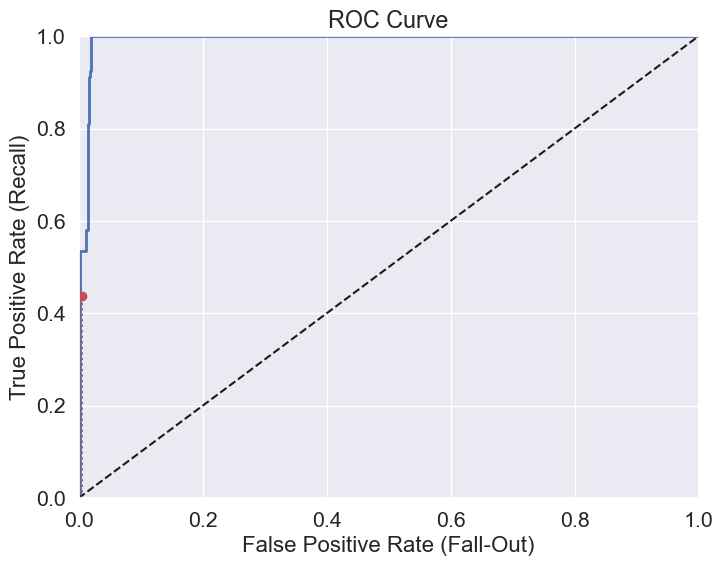

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")  
plt.title('ROC Curve')
roc_curve = plt.show()
roc_curve